This notebook is used to create the Gasunie scenario analysis plots over time. It includes lineplots, chloropleths over time and other plots.

In [2]:
# import packages

import numpy as np 
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join

%matplotlib inline
import seaborn as sns
import matplotlib. pyplot as plt # for plotting graphs
import matplotlib.mlab as mlab # 
import matplotlib
plt.style.use('ggplot') # basic, but functional, plotstyle,
from matplotlib.pyplot import figure
matplotlib.rcParams['figure.figsize'] = (12,8)
import matplotlib.gridspec as GridSpec

# https://docs.bokeh.org/en/latest/docs/user_guide/categorical.html

from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.plotting import figure
from bokeh.palettes import Spectral, GnBu, PuBuGn, Set1
from bokeh.io import output_notebook
from bokeh.io import export_png

In [122]:
# load data

# CBS geodata
# CBS dataset
municipalities_input = gpd.read_file("/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Data/Output/Gemeente/04_08/municipalities.shp")

#scenario = 'G1'
#df = pd.read_csv("/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Input data/Municipalities_26_08_experimentation_kw G1-table.csv", header = 6, sep = ",")

#scenario = 'G2'
#df = pd.read_csv("/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Input data/Municipalities_26_08_experimentation_kw G2-table.csv", header = 6, sep = ",")

#scenario = 'G3'
#df = pd.read_csv("/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Input data/Municipalities_26_08_experimentation_kw G3-table.csv", header = 6, sep = ",")

#scenario = 'G4'
#df = pd.read_csv("/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Input data/Municipalities_26_08_experimentation_kw G4-table.csv", header = 6, sep = ",")

#scenario = 'G5'
#df = pd.read_csv("/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Input data/Municipalities_26_08_experimentation_kw G5-table.csv", header = 6, sep = ",")

#scenario = 'G6'
#df = pd.read_csv("/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Input data/Municipalities_26_08_experimentation_kw G6-table.csv", header = 6, sep = ",")

#scenario = 'G7'
#df = pd.read_csv("/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Input data/Municipalities_26_08_experimentation_kw G7-table.csv", header = 6, sep = ",")

scenario = 'G8'
df = pd.read_csv("/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Input data/Municipalities_26_08_experimentation_kw G8-table.csv", header = 6, sep = ",")




In [101]:
# Selection tool

y1 = 2030
y2 = 2040
y3 = 2050

In [102]:
# scenario

df[['nh-ins-strategy1', 'national-gg-potential-PJ', 'national-h2-availability-ticks']].describe()

,nh-ins-strategy1,national-gg-potential-PJ,national-h2-availability-ticks
count,3200.0,3200.0,3200.0
mean,40.0,60.0,15.0
std,0.0,0.0,0.0
min,40.0,60.0,15.0
25%,40.0,60.0,15.0
50%,40.0,60.0,15.0
75%,40.0,60.0,15.0
max,40.0,60.0,15.0


In [103]:
# data preparation

# add all output columns kw's, kws and tpp to municipalities
columns = (df.columns.str.contains('output-mr') & df.columns.str.contains('kw'))
df_geo = df.loc[:,(columns) ].copy()
df_geo['[run number]'] = df['[run number]'].copy()
df_geo['[step]'] = df['[step]'].copy()

df_geo_melted = df_geo.melt(id_vars = ['[run number]', '[step]'], var_name = 'output_type', value_name = 'output')
df_geo_melted['MR'] = df_geo_melted['output_type'].str.replace('output-mr-','').str.replace('-ng-kw','').str.replace('-gg-kw','').str.replace('-h2-kw','').str.replace('-e-kw','').str.replace('-h-kw','').str.capitalize()
df_geo_melted_mean = df_geo_melted.groupby(['[step]', 'output_type', 'MR'], as_index = False).mean()
df_geo_melted_mean['[step]'] = df_geo_melted_mean['[step]'] + 2019
df_geo_melted_mean['output_type'] = df_geo_melted_mean['output_type'].str[-5:]

# create all-gas (ag-kw) and methane-gas (mg-kw) output

# Merge df's
municipalities_input['Station 1'] = municipalities_input['Station 1'].str.replace(" ", "").str.capitalize()
mp_mr = pd.merge(municipalities_input, df_geo_melted_mean, how = 'left', left_on = 'Station 1', right_on = 'MR')




In [6]:
def output_t0(row):
    output_t0 = mp_mr['output'][(mp_mr['GM_NAAM'] == row.GM_NAAM) & (mp_mr['Station 1'] == row['Station 1']) & (mp_mr['[step]'] == 2020) & (mp_mr['output_type'] == row.output_type)].mean()
    return output_t0

In [7]:
# Lookup t0 value for every year
mp_mr['output_t0'] = mp_mr.apply(lambda row: output_t0(row), axis = 1)

In [8]:
# plottable geomaps per year per output --> year selection 1

# single gas
MR_stepy1_ng = mp_mr[(mp_mr['[step]'] == y1) & (mp_mr['output_type'] == 'ng-kw')].dissolve(by='Station 1')
MR_stepy1_gg = mp_mr[(mp_mr['[step]'] == y1) & (mp_mr['output_type'] == 'gg-kw')].dissolve(by='Station 1')
MR_stepy1_h2 = mp_mr[(mp_mr['[step]'] == y1) & (mp_mr['output_type'] == 'h2-kw')].dissolve(by='Station 1')

# multigas
MR_stepy1_ng_gg = MR_stepy1_ng.copy()
MR_stepy1_ng_gg['output'] = MR_stepy1_ng_gg['output'] + MR_stepy1_gg['output']

MR_stepy1_ng_gg_h2 = MR_stepy1_ng_gg.copy()
MR_stepy1_ng_gg_h2['output'] = MR_stepy1_ng_gg_h2['output'] + MR_stepy1_h2['output']

# e and h
MR_stepy1_e = mp_mr[(mp_mr['[step]'] == y1) & (mp_mr['output_type'] == '-e-kw')].dissolve(by='Station 1')
MR_stepy1_h = mp_mr[(mp_mr['[step]'] == y1) & (mp_mr['output_type'] == '-h-kw')].dissolve(by='Station 1')

# relative to t0 %
MR_stepy1_ng['relative_output'] = MR_stepy1_ng['output'] / MR_stepy1_ng['output_t0'] - 1
MR_stepy1_ng_gg['relative_output'] = MR_stepy1_ng_gg['output'] / MR_stepy1_ng_gg['output_t0'] - 1
MR_stepy1_ng_gg_h2['relative_output'] = MR_stepy1_ng_gg_h2['output'] / MR_stepy1_ng_gg_h2['output_t0'] - 1

In [9]:
# plottable geomaps per year per output --> year selection 2

# single gas
MR_stepy2_ng = mp_mr[(mp_mr['[step]'] == y2) & (mp_mr['output_type'] == 'ng-kw')].dissolve(by='Station 1')
MR_stepy2_gg = mp_mr[(mp_mr['[step]'] == y2) & (mp_mr['output_type'] == 'gg-kw')].dissolve(by='Station 1')
MR_stepy2_h2 = mp_mr[(mp_mr['[step]'] == y2) & (mp_mr['output_type'] == 'h2-kw')].dissolve(by='Station 1')

# multigas
MR_stepy2_ng_gg = MR_stepy2_ng.copy()
MR_stepy2_ng_gg['output'] = MR_stepy2_ng_gg['output'] + MR_stepy2_gg['output']

MR_stepy2_ng_gg_h2 = MR_stepy2_ng_gg.copy()
MR_stepy2_ng_gg_h2['output'] = MR_stepy2_ng_gg_h2['output'] + MR_stepy2_h2['output']

# e and h
MR_stepy2_e = mp_mr[(mp_mr['[step]'] == y2) & (mp_mr['output_type'] == '-e-kw')].dissolve(by='Station 1')
MR_stepy2_h = mp_mr[(mp_mr['[step]'] == y2) & (mp_mr['output_type'] == '-h-kw')].dissolve(by='Station 1')

# relative to t0 %
MR_stepy2_ng['relative_output'] = MR_stepy2_ng['output'] / MR_stepy2_ng['output_t0'] - 1
MR_stepy2_ng_gg['relative_output'] = MR_stepy2_ng_gg['output'] / MR_stepy2_ng_gg['output_t0'] - 1
MR_stepy2_ng_gg_h2['relative_output'] = MR_stepy2_ng_gg_h2['output'] / MR_stepy2_ng_gg_h2['output_t0'] - 1

In [10]:
# plottable geomaps per year per output --> y3

# single gas
MR_stepy3_ng = mp_mr[(mp_mr['[step]'] == y3) & (mp_mr['output_type'] == 'ng-kw')].dissolve(by='Station 1')
MR_stepy3_gg = mp_mr[(mp_mr['[step]'] == y3) & (mp_mr['output_type'] == 'gg-kw')].dissolve(by='Station 1')
MR_stepy3_h2 = mp_mr[(mp_mr['[step]'] == y3) & (mp_mr['output_type'] == 'h2-kw')].dissolve(by='Station 1')

# multigas
MR_stepy3_ng_gg = MR_stepy3_ng.copy()
MR_stepy3_ng_gg['output'] = MR_stepy3_ng_gg['output'] + MR_stepy3_gg['output']

MR_stepy3_ng_gg_h2 = MR_stepy3_ng_gg.copy()
MR_stepy3_ng_gg_h2['output'] = MR_stepy3_ng_gg_h2['output'] + MR_stepy3_h2['output']

# e and h
MR_stepy3_e = mp_mr[(mp_mr['[step]'] == y3) & (mp_mr['output_type'] == '-e-kw')].dissolve(by='Station 1')
MR_stepy3_h = mp_mr[(mp_mr['[step]'] == y3) & (mp_mr['output_type'] == '-h-kw')].dissolve(by='Station 1')

# relative to t0 %
MR_stepy3_ng['relative_output'] = MR_stepy3_ng['output'] / MR_stepy3_ng['output_t0'] - 1
MR_stepy3_ng_gg['relative_output'] = MR_stepy3_ng_gg['output'] / MR_stepy3_ng_gg['output_t0'] - 1
MR_stepy3_ng_gg_h2['relative_output'] = MR_stepy3_ng_gg_h2['output'] / MR_stepy3_ng_gg_h2['output_t0'] - 1

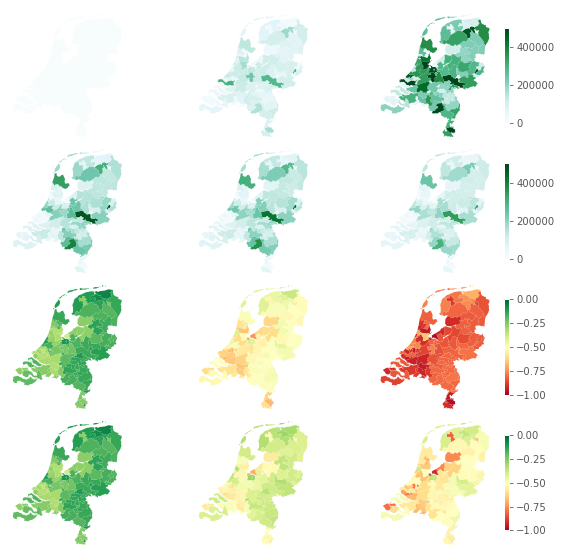

In [11]:
# plot relative gas maps: h2, greengas, methane, all gas

import matplotlib.gridspec as gridspec

# gridspec
gs = gridspec.GridSpec(nrows = 4, ncols = 3, wspace = 0, hspace = 0)
fig = plt.figure(figsize = (10,10))
fig.tight_layout(pad=0)

vmax_h2 = 500000
vmin_h2 = 0
vmax_gg = 500000
vmin_gg = -1
vmax_ng_gg = 0
vmin_ng_gg = -1
vmax_ng_gg_h2 = 0
vmin_ng_gg_h2 = -1
cmap_ng = 'Greys'
cmap_gg = 'BuGn'
cmap_h2 = 'BuGn'
cmap_ng_gg = 'RdYlGn'
cmap_ng_gg_h2 = 'RdYlGn'

#title = 'Gasunie Scenario:' + scenario
#fig.suptitle(title, fontsize=16)

# y1 relative
# y1

# h2
ax0 = fig.add_subplot(gs[0,0])
#ax0.set_ylabel('Hydrogen')
MR_stepy1_h2.plot(ax = ax0, column='output', legend = False, legend_kwds={'shrink': 1}, vmax = vmax_h2, vmin = vmin_h2, cmap = cmap_h2).set_axis_off()
# gg
ax1 = fig.add_subplot(gs[1,0])
#ax1.set_ylabel('Green Gas')
MR_stepy1_gg.plot(ax = ax1, column='output', legend = False, legend_kwds={'shrink': 1}, vmax = vmax_gg, vmin = vmin_gg, cmap = cmap_gg).set_axis_off()
# mg
ax2 = fig.add_subplot(gs[2,0])
#ax2.set_ylabel('Methane Gas')
MR_stepy1_ng_gg.plot(ax = ax2, column='relative_output', legend = False, legend_kwds={'shrink': 1}, vmax = vmax_ng_gg, vmin = vmin_ng_gg, cmap = cmap_ng_gg).set_axis_off()
# ag
ax3 = fig.add_subplot(gs[3,0])
#ax3.set_ylabel('All Gas')
MR_stepy1_ng_gg_h2.plot(ax = ax3, column='relative_output', legend = False, legend_kwds={'shrink': 1}, vmax = vmax_ng_gg_h2, vmin = vmin_ng_gg_h2, cmap = cmap_ng_gg_h2).set_axis_off()

# y2 relative
# y2

# h2
ax4 = fig.add_subplot(gs[0,1])
MR_stepy2_h2.plot(ax = ax4, column='output', legend = False, legend_kwds={'shrink': 1}, vmax = vmax_h2, vmin = vmin_h2, cmap = cmap_h2).set_axis_off()
# gg
ax5 = fig.add_subplot(gs[1,1])
MR_stepy2_gg.plot(ax = ax5, column='output', legend = False, legend_kwds={'shrink': 1}, vmax = vmax_gg, vmin = vmin_gg, cmap = cmap_gg).set_axis_off()
# mg
ax6 = fig.add_subplot(gs[2,1])
MR_stepy2_ng_gg.plot(ax = ax6, column='relative_output', legend = False, legend_kwds={'shrink': 1}, vmax = vmax_ng_gg, vmin = vmin_ng_gg, cmap = cmap_ng_gg).set_axis_off()
# ag
ax7 = fig.add_subplot(gs[3,1])
MR_stepy2_ng_gg_h2.plot(ax = ax7, column='relative_output', legend = False, legend_kwds={'shrink': 1}, vmax = vmax_ng_gg_h2, vmin = vmin_ng_gg_h2, cmap = cmap_ng_gg_h2).set_axis_off()

# y3 relative
# y3

# h2
ax8 = fig.add_subplot(gs[0,2])
MR_stepy3_h2.plot(ax = ax8, column='output', legend = True, legend_kwds={'shrink': 0.7}, vmax = vmax_h2, vmin = vmin_h2, cmap = cmap_h2).set_axis_off()
# gg
ax9 = fig.add_subplot(gs[1,2])
MR_stepy3_gg.plot(ax = ax9, column='output', legend = True, legend_kwds={'shrink': 0.7}, vmax = vmax_gg, vmin = vmin_gg, cmap = cmap_gg).set_axis_off()
# mg
ax10 = fig.add_subplot(gs[2,2])
MR_stepy3_ng_gg.plot(ax = ax10, column='relative_output', legend = True, legend_kwds={'shrink': 0.7}, vmax = vmax_ng_gg, vmin = vmin_ng_gg, cmap = cmap_ng_gg).set_axis_off()
# ag
ax11 = fig.add_subplot(gs[3,2])
MR_stepy3_ng_gg_h2.plot(ax = ax11, column='relative_output', legend = True, legend_kwds={'shrink': 0.7}, vmax = vmax_ng_gg_h2, vmin = vmin_ng_gg_h2, cmap = cmap_ng_gg_h2).set_axis_off()

# axis and legend text in post-processing lucidchart!

filepath = '/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Output/'
filemarker = 'MAP'
fullfile = filepath + filemarker + '_' + scenario
fig.savefig(fullfile, dpi=400)

In [ ]:
# plot NL gasses development 



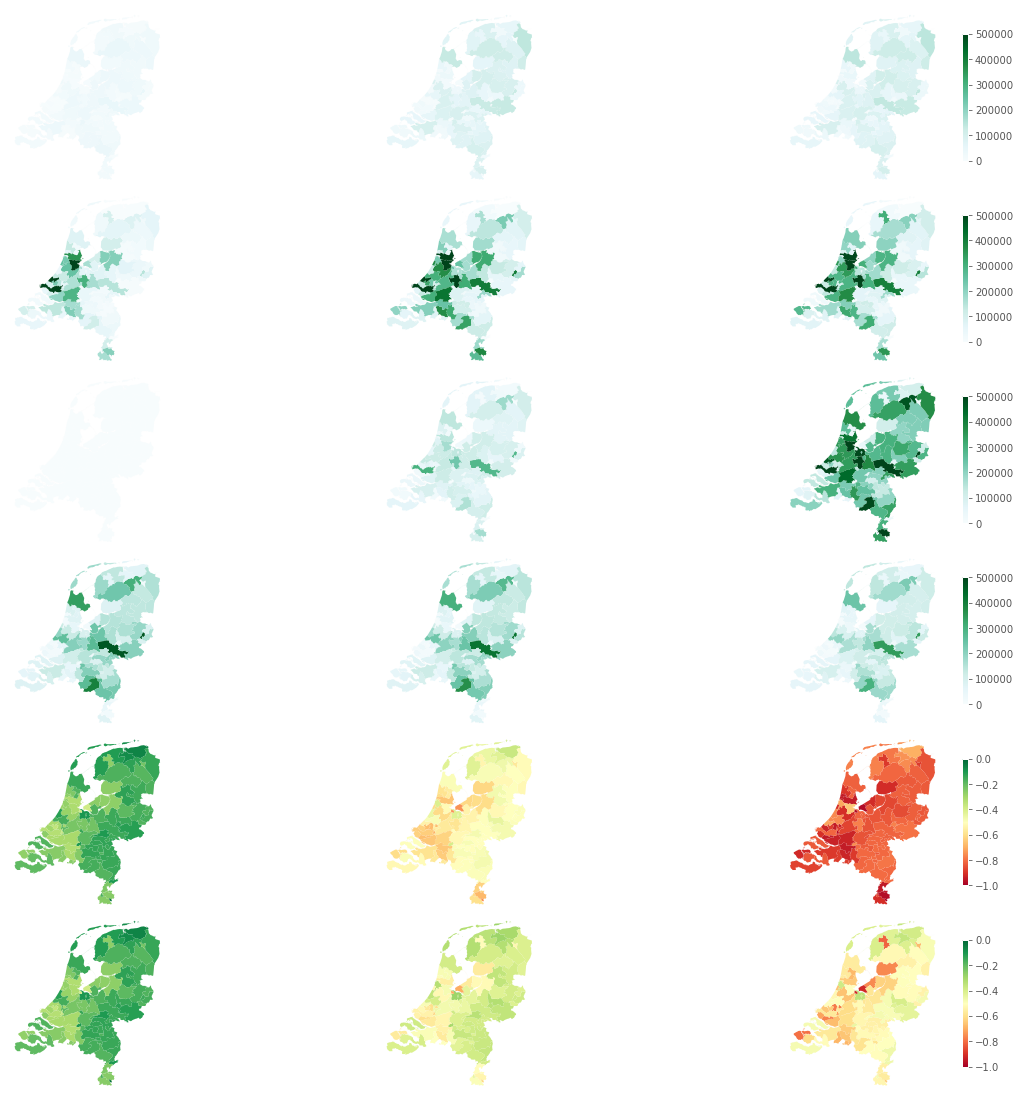

In [12]:
# plot relative gas maps: h2, greengas, methane, all gas

import matplotlib.gridspec as gridspec

# gridspec
gs = gridspec.GridSpec(nrows = 6, ncols = 3, wspace = 0, hspace = 0)
fig = plt.figure(figsize = (20,20))
fig.tight_layout(pad=0)


vmax_e = 500000
vmin_e = 0
vmax_h = 500000
vmin_h = 0
vmax_h2 = 500000
vmin_h2 = 0
vmax_gg = 500000
vmin_gg = 0
vmax_ng_gg = 0
vmin_ng_gg = -1
vmax_ng_gg_h2 = 0
vmin_ng_gg_h2 = -1
cmap_ng = 'Greys'
cmap_e = 'BuGn'
cmap_h = 'BuGn'
cmap_gg = 'BuGn'
cmap_h2 = 'BuGn'
cmap_ng_gg = 'RdYlGn'
cmap_ng_gg_h2 = 'RdYlGn'

#title = 'Gasunie Scenario:' + scenario
#fig.suptitle(title, fontsize=16)

# y1 relative
# y1

# e
ax0 = fig.add_subplot(gs[0,0])
MR_stepy1_e.plot(ax = ax0, column='output', legend = False, legend_kwds={'shrink': 1}, vmax = vmax_e, vmin = vmin_e, cmap = cmap_e).set_axis_off()
# h
ax1 = fig.add_subplot(gs[1,0])
MR_stepy1_h.plot(ax = ax1, column='output', legend = False, legend_kwds={'shrink': 1}, vmax = vmax_h, vmin = vmin_h, cmap = cmap_h).set_axis_off()
# h2
ax2 = fig.add_subplot(gs[2,0])
MR_stepy1_h2.plot(ax = ax2, column='output', legend = False, legend_kwds={'shrink': 1}, vmax = vmax_h2, vmin = vmin_h2, cmap = cmap_h2).set_axis_off()
# gg
ax3 = fig.add_subplot(gs[3,0])
MR_stepy1_gg.plot(ax = ax3, column='output', legend = False, legend_kwds={'shrink': 1}, vmax = vmax_gg, vmin = vmin_gg, cmap = cmap_gg).set_axis_off()
# mg
ax4 = fig.add_subplot(gs[4,0])
MR_stepy1_ng_gg.plot(ax = ax4, column='relative_output', legend = False, legend_kwds={'shrink': 1}, vmax = vmax_ng_gg, vmin = vmin_ng_gg, cmap = cmap_ng_gg).set_axis_off()
# ag
ax5 = fig.add_subplot(gs[5,0])
MR_stepy1_ng_gg_h2.plot(ax = ax5, column='relative_output', legend = False, legend_kwds={'shrink': 1}, vmax = vmax_ng_gg_h2, vmin = vmin_ng_gg_h2, cmap = cmap_ng_gg_h2).set_axis_off()

# y2 relative
# y2
# e
ax6 = fig.add_subplot(gs[0,1])
MR_stepy2_e.plot(ax = ax6, column='output', legend = False, legend_kwds={'shrink': 1}, vmax = vmax_e, vmin = vmin_e, cmap = cmap_e).set_axis_off()
# h
ax7 = fig.add_subplot(gs[1,1])
MR_stepy2_h.plot(ax = ax7, column='output', legend = False, legend_kwds={'shrink': 1}, vmax = vmax_h, vmin = vmin_h, cmap = cmap_h).set_axis_off()
# h2
ax8 = fig.add_subplot(gs[2,1])
MR_stepy2_h2.plot(ax = ax8, column='output', legend = False, legend_kwds={'shrink': 1}, vmax = vmax_h2, vmin = vmin_h2, cmap = cmap_h2).set_axis_off()
# gg
ax9 = fig.add_subplot(gs[3,1])
MR_stepy2_gg.plot(ax = ax9, column='output', legend = False, legend_kwds={'shrink': 1}, vmax = vmax_gg, vmin = vmin_gg, cmap = cmap_gg).set_axis_off()
# mg
ax10 = fig.add_subplot(gs[4,1])
MR_stepy2_ng_gg.plot(ax = ax10, column='relative_output', legend = False, legend_kwds={'shrink': 1}, vmax = vmax_ng_gg, vmin = vmin_ng_gg, cmap = cmap_ng_gg).set_axis_off()
# ag
ax11 = fig.add_subplot(gs[5,1])
MR_stepy2_ng_gg_h2.plot(ax = ax11, column='relative_output', legend = False, legend_kwds={'shrink': 1}, vmax = vmax_ng_gg_h2, vmin = vmin_ng_gg_h2, cmap = cmap_ng_gg_h2).set_axis_off()

# y3 relative
# y3
ax12 = fig.add_subplot(gs[0,2])
MR_stepy3_e.plot(ax = ax12, column='output', legend = True, legend_kwds={'shrink': 0.7}, vmax = vmax_e, vmin = vmin_e, cmap = cmap_e).set_axis_off()
# h
ax13 = fig.add_subplot(gs[1,2])
MR_stepy3_h.plot(ax = ax13, column='output', legend = True, legend_kwds={'shrink': 0.7}, vmax = vmax_h, vmin = vmin_h, cmap = cmap_h).set_axis_off()
# h2
ax14 = fig.add_subplot(gs[2,2])
MR_stepy3_h2.plot(ax = ax14, column='output', legend = True, legend_kwds={'shrink': 0.7}, vmax = vmax_h2, vmin = vmin_h2, cmap = cmap_h2).set_axis_off()
# gg
ax15 = fig.add_subplot(gs[3,2])
MR_stepy3_gg.plot(ax = ax15, column='output', legend = True, legend_kwds={'shrink': 0.7}, vmax = vmax_gg, vmin = vmin_gg, cmap = cmap_gg).set_axis_off()
# mg
ax16 = fig.add_subplot(gs[4,2])
MR_stepy3_ng_gg.plot(ax = ax16, column='relative_output', legend = True, legend_kwds={'shrink': 0.7}, vmax = vmax_ng_gg, vmin = vmin_ng_gg, cmap = cmap_ng_gg).set_axis_off()
# ag
ax17 = fig.add_subplot(gs[5,2])
MR_stepy3_ng_gg_h2.plot(ax = ax17, column='relative_output', legend = True, legend_kwds={'shrink': 0.7}, vmax = vmax_ng_gg_h2, vmin = vmin_ng_gg_h2, cmap = cmap_ng_gg_h2).set_axis_off()

# axis and legend text in post-processing lucidchart!

filepath = '/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Output/'
filemarker = 'MAP'
fullfile = filepath + filemarker + '_' + scenario + 'all_energy'
fig.savefig(fullfile, dpi=400)

In [1]:
# NL lineplots for gasunie scenarios

In [123]:
# data preparation

# add all output columns kw's, kws and tpp to municipalities
columns = (df.columns.str.contains('output-nl') & df.columns.str.contains('kw'))
df_nl = df.loc[:,(columns) ].copy()
df_nl['[run number]'] = df['[run number]'].copy()
df_nl['[step]'] = df['[step]'].copy()
df_nl['[step]'] = df_nl['[step]'] + 2019
df_nl = df_nl[df_nl['[step]'] > 2019]
df_nl = df_nl.drop(['output-nl-kw', '[run number]'], axis = 1)
df_nl_grouped = df_nl.groupby('[step]').mean()
df_nl_grouped = df_nl_grouped[['output-nl-ng-kw', 'output-nl-gg-kw', 'output-nl-h2-kw', 'output-nl-e-kw', 'output-nl-h-kw']]
df_nl_grouped = df_nl_grouped.rename(columns={"output-nl-ng-kw": "Natural Gas", "output-nl-gg-kw": "Green Gas", "output-nl-h2-kw": "Hydrogen Gas", "output-nl-e-kw": "Electricity", "output-nl-h-kw": "Heat"})
# create all-gas (ag-kw) and methane-gas (mg-kw) output

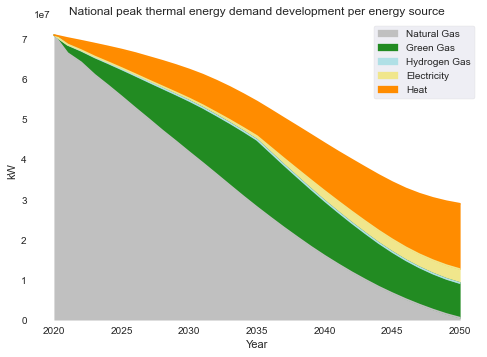

In [124]:
fig = df_nl_grouped.plot.area( color = ['silver', 'forestgreen', 'powderblue', 'khaki', 'darkorange'])
fig.set_facecolor("white")
fig.legend(frameon= True)
plt.xlabel('Year')
plt.ylabel('kW')
plt.style.use('seaborn')
plt.title('National peak thermal energy demand development per energy source')

filepath = '/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Output/'
filemarker = 'plot_stacked'
fullfile = filepath + filemarker + '_' + scenario
plt.savefig(fullfile, dpi=400)

In [ ]:
# stacked plots for MR




In [3]:
#scenario = 'G1'
df1 = pd.read_csv("/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Input data/Municipalities_26_08_experimentation_kw G1-table.csv", header = 6, sep = ",")

#scenario = 'G2'
df2 = pd.read_csv("/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Input data/Municipalities_26_08_experimentation_kw G2-table.csv", header = 6, sep = ",")

#scenario = 'G3'
df3 = pd.read_csv("/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Input data/Municipalities_26_08_experimentation_kw G3-table.csv", header = 6, sep = ",")

#scenario = 'G4'
df4 = pd.read_csv("/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Input data/Municipalities_26_08_experimentation_kw G4-table.csv", header = 6, sep = ",")

#scenario = 'G5'
df5 = pd.read_csv("/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Input data/Municipalities_26_08_experimentation_kw G5-table.csv", header = 6, sep = ",")

#scenario = 'G6'
df6 = pd.read_csv("/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Input data/Municipalities_26_08_experimentation_kw G6-table.csv", header = 6, sep = ",")

#scenario = 'G7'
df7 = pd.read_csv("/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Input data/Municipalities_26_08_experimentation_kw G7-table.csv", header = 6, sep = ",")

#scenario = 'G8'
df8 = pd.read_csv("/Users/jaromirbogdanovski/Documents/Studie/EPA/Master Thesis/Igor Nikolic/Coding/Experimentation/Input data/Municipalities_26_08_experimentation_kw G8-table.csv", header = 6, sep = ",")

In [4]:
# concat dfs

df_all = pd.concat([df1.assign(scenario='G1'), df2.assign(scenario='G2'), df3.assign(scenario='G3'),
                   df4.assign(scenario='G4'), df5.assign(scenario='G5'), df6.assign(scenario='G6'),
                   df7.assign(scenario='G7'), df8.assign(scenario='G8')])

In [5]:
# melt dfs

columns = ['output-nl-ng-kw', 'output-nl-gg-kw', 'output-nl-h2-kw', 'output-nl-e-kw', 'output-nl-h-kw']
df_selected = df_all.loc[:,(columns) ].copy()
df_selected['[run number]'] = df_all['[run number]']
df_selected['[step]'] = df_all['[step]'] + 2019
df_selected['scenario'] = df_all['scenario']
df_selected = df_selected[df_selected['[step]'] > 2019]
df_selected['Methane Gas'] = df_selected['output-nl-ng-kw'] + df_selected['output-nl-gg-kw']
df_selected['All Gas'] = df_selected['output-nl-ng-kw'] + df_selected['output-nl-gg-kw'] + df_selected['output-nl-h2-kw']

df_selected = df_selected.rename(columns={"output-nl-ng-kw": "Natural Gas", "output-nl-gg-kw": "Green Gas", "output-nl-h2-kw": "Hydrogen Gas", "output-nl-e-kw": "Electricity", "output-nl-h-kw": "Heat"})

df_melted = df_selected.melt(id_vars = ['[run number]', '[step]', 'scenario'], var_name = 'output_type', value_name = 'output' )
df_melted = df_melted[df_melted['[step]'] > 2019]
df_melted



,[run number],[step],scenario,output_type,output
0,1,2020,G1,Natural Gas,7.139181e+07
1,1,2021,G1,Natural Gas,6.727797e+07
2,1,2022,G1,Natural Gas,6.535194e+07
3,1,2023,G1,Natural Gas,6.245765e+07
4,1,2024,G1,Natural Gas,6.025611e+07
...,...,...,...,...,...
173595,99,2049,G8,All Gas,1.028255e+07
173596,98,2050,G8,All Gas,9.223600e+06
173597,100,2049,G8,All Gas,1.022996e+07
173598,99,2050,G8,All Gas,9.218410e+06


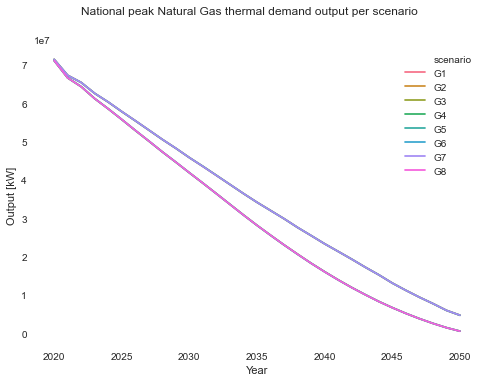

In [168]:
# NL NG per scenario

sns.set_style('white')
plt.suptitle('National peak Natural Gas thermal demand output per scenario', fontsize = 12)

x = '[step]'
y = 'output'

sns.lineplot(x=x, y=y, hue = 'scenario', data=df_melted[df_melted['output_type'] == 'Natural Gas'])
plt.xlabel('Year')
plt.ylabel('Output [kW]')

NL_file = filepath + 'Gasunie_NG'
plt.savefig(NL_file)

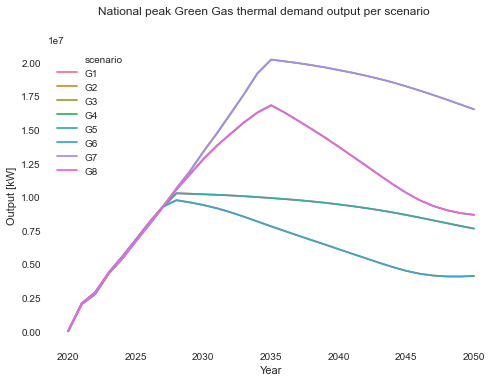

In [170]:
# NL GG per scenario

sns.set_style('white')
plt.suptitle('National peak Green Gas thermal demand output per scenario', fontsize = 12)

x = '[step]'
y = 'output'

sns.lineplot(x=x, y=y, hue = 'scenario', data=df_melted[df_melted['output_type'] == 'Green Gas'])
plt.xlabel('Year')
plt.ylabel('Output [kW]')

NL_file = filepath + 'Gasunie_GG'
plt.savefig(NL_file)

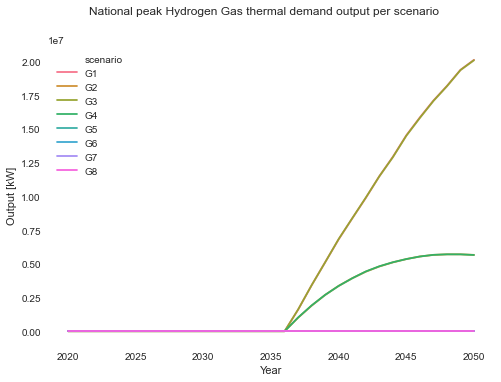

In [171]:
# NL H2 per scenario

sns.set_style('white')
plt.suptitle('National peak Hydrogen Gas thermal demand output per scenario', fontsize = 12)

x = '[step]'
y = 'output'

sns.lineplot(x=x, y=y, hue = 'scenario', data=df_melted[df_melted['output_type'] == 'Hydrogen Gas'])
plt.xlabel('Year')
plt.ylabel('Output [kW]')

NL_file = filepath + 'Gasunie_H2'
plt.savefig(NL_file)

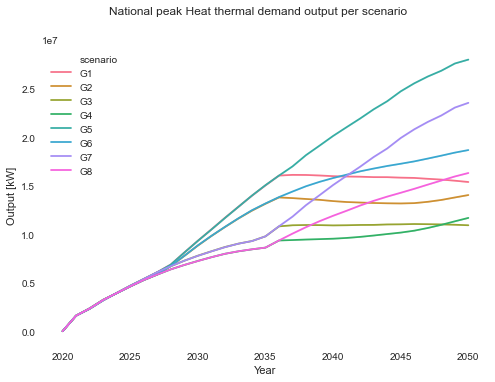

In [172]:
# NL H per scenario

sns.set_style('white')
plt.suptitle('National peak Heat thermal demand output per scenario', fontsize = 12)

x = '[step]'
y = 'output'

sns.lineplot(x=x, y=y, hue = 'scenario', data=df_melted[df_melted['output_type'] == 'Heat'])
plt.xlabel('Year')
plt.ylabel('Output [kW]')

NL_file = filepath + 'Gasunie_H'
plt.savefig(NL_file)

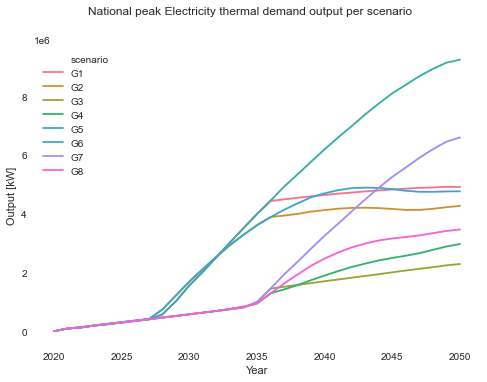

In [173]:
# NL E per scenario

sns.set_style('white')
plt.suptitle('National peak Electricity thermal demand output per scenario', fontsize = 12)

x = '[step]'
y = 'output'

sns.lineplot(x=x, y=y, hue = 'scenario', data=df_melted[df_melted['output_type'] == 'Electricity'])
plt.xlabel('Year')
plt.ylabel('Output [kW]')

NL_file = filepath + 'Gasunie_E'
plt.savefig(NL_file)

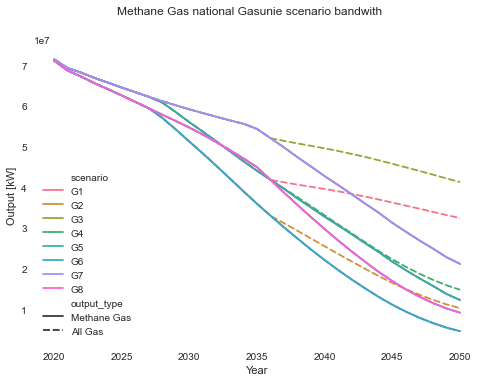

In [184]:
# Methane Gas bandwith

sns.set_style('white')
plt.suptitle('Methane Gas national Gasunie scenario bandwith', fontsize = 12)

x = '[step]'
y = 'output'

sns.lineplot(x=x, y=y, hue = 'scenario', style = 'output_type' ,data = df_melted[(df_melted['output_type'] == 'Methane Gas') |(df_melted['output_type'] == 'All Gas')  ])
plt.xlabel('Year')
plt.ylabel('Output [kW]')

NL_file = filepath + 'Gasunie_NLbandwith'
plt.savefig(NL_file)

In [7]:
df_melted[(df_melted['[step]'] == 2020) & (df_melted['output_type'] == 'Methane Gas')].sort_values(by='output', ascending = True)

,[run number],[step],scenario,output_type,output
129712,90,2020,G2,Methane Gas,7.108278e+07
135028,61,2020,G4,Methane Gas,7.108278e+07
129730,93,2020,G2,Methane Gas,7.108278e+07
134649,49,2020,G4,Methane Gas,7.108278e+07
141032,55,2020,G6,Methane Gas,7.108278e+07
...,...,...,...,...,...
145197,87,2020,G7,Methane Gas,7.139181e+07
145205,91,2020,G7,Methane Gas,7.139181e+07
137090,26,2020,G5,Methane Gas,7.139181e+07
132464,81,2020,G3,Methane Gas,7.139181e+07


In [6]:
df_melted[(df_melted['[step]'] == 2050) & (df_melted['output_type'] == 'Methane Gas')].sort_values(by='output', ascending = True)

,[run number],[step],scenario,output_type,output
141962,74,2050,G6,Methane Gas,4.535732e+06
130096,95,2050,G2,Methane Gas,4.546431e+06
130070,90,2050,G2,Methane Gas,4.550050e+06
127829,18,2050,G2,Methane Gas,4.563328e+06
139915,7,2050,G6,Methane Gas,4.564683e+06
...,...,...,...,...,...
143341,19,2050,G7,Methane Gas,2.133883e+07
144811,65,2050,G7,Methane Gas,2.137220e+07
142956,3,2050,G7,Methane Gas,2.139356e+07
145696,98,2050,G7,Methane Gas,2.139797e+07


In [9]:
# MG max decline nationally
1 - (4.535732e+6 / 7.108278e+7)

0.9361908467845518

In [10]:
# MG min decline nationally
1 - (2.143615e+07 / 7.108278e+7)

0.6984339948437582

In [13]:
df_melted[(df_melted['[step]'] == 2020) & (df_melted['output_type'] == 'All Gas')].sort_values(by='output', ascending = True)

,[run number],[step],scenario,output_type,output
154512,90,2020,G2,All Gas,7.108278e+07
159828,61,2020,G4,All Gas,7.108278e+07
154530,93,2020,G2,All Gas,7.108278e+07
159449,49,2020,G4,All Gas,7.108278e+07
165832,55,2020,G6,All Gas,7.108278e+07
...,...,...,...,...,...
169997,87,2020,G7,All Gas,7.139181e+07
170005,91,2020,G7,All Gas,7.139181e+07
161890,26,2020,G5,All Gas,7.139181e+07
157264,81,2020,G3,All Gas,7.139181e+07


In [15]:
df_melted[(df_melted['[step]'] == 2050) & (df_melted['output_type'] == 'All Gas')].sort_values(by='output', ascending = True)

,[run number],[step],scenario,output_type,output
166762,74,2050,G6,All Gas,4.535732e+06
164715,7,2050,G6,All Gas,4.564683e+06
165292,26,2050,G6,All Gas,4.571630e+06
165826,44,2050,G6,All Gas,4.576886e+06
165872,47,2050,G6,All Gas,4.579650e+06
...,...,...,...,...,...
157571,76,2050,G3,All Gas,4.148891e+07
157248,69,2050,G3,All Gas,4.151226e+07
156894,60,2050,G3,All Gas,4.153628e+07
157603,79,2050,G3,All Gas,4.157418e+07


In [16]:
# AG max decline nationally
1 - (4.535732e+6 / 7.108278e+7)

0.9361908467845518

In [18]:
# MG min decline nationally
1 - (4.161565e+7 / 7.108278e+7)

0.4145466736106832